# Regression with Neural Networks

In [1]:
import os
import sys

current_path = os.getcwd()
sys.path.append(current_path + '\..')


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

# Import self-made modules
from project2_code import *

### Make and prepare data

In [2]:
n = 1000
np.random.seed(1)
x = 10*np.random.rand(n)

# Make second degree polynomial
y = 2 - 5*x + x**2 + np.random.normal(scale = 0.1, size = len(x))

# Create design matrix, up to second degree
X = create_design_matrix_1d(x, 2)

# Split data in train, validation and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_train, y_train, test_size = 0.5, random_state=1)

# Scale the data
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

## Train Neural Network for regression

0.40475426342645104


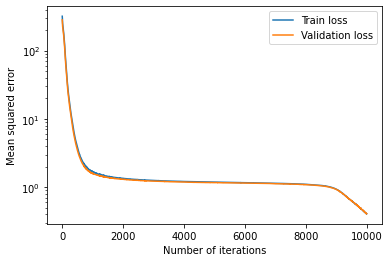

In [32]:
num_epochs = 10000
minibatches = 5
learning_rate = 0.0001
lamb = 0


network = NeuralNetwork(X_train_scaled.shape[1])        
network.add_layer(8)
network.add_layer(8)
network.add_layer(1)   
    
network.train(X_train_scaled, y_train, minibatches=minibatches, num_epochs = num_epochs, learning_rate=learning_rate, reg_coef=lamb, return_loss=True, loss='MSE', data_val=X_val_scaled, target_val=y_val)
print(min(network.loss_train)) 

plt.plot(range(num_epochs), network.loss_train, label='Train loss');
plt.plot(range(num_epochs), network.loss_val, label='Validation loss');
plt.xlabel('Number of iterations');
plt.ylabel('Mean squared error')
plt.legend()
plt.yscale('log')
plt.savefig('..\\..\\output\\figures\\NNregr_2layers_8nodes.jpg')

0.018445503420337937


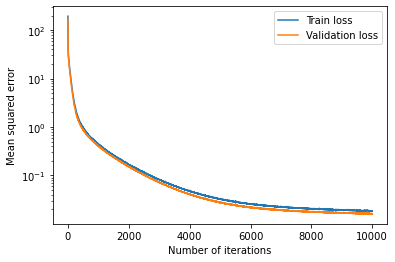

In [31]:
num_epochs = 10000
minibatches = 5
learning_rate = 0.0001
lamb = 0


network = NeuralNetwork(X_train_scaled.shape[1])        
network.add_layer(100)
network.add_layer(1)   
    
network.train(X_train_scaled, y_train, minibatches=minibatches, num_epochs = num_epochs, learning_rate=learning_rate, reg_coef=lamb, return_loss=True, loss='MSE', data_val=X_val_scaled, target_val=y_val)
print(min(network.loss_train)) 

plt.plot(range(num_epochs), network.loss_train, label='Train loss');
plt.plot(range(num_epochs), network.loss_val, label='Validation loss');
plt.xlabel('Number of iterations');
plt.ylabel('Mean squared error')
plt.legend()
plt.yscale('log')
plt.savefig('..\\..\\output\\figures\\NNregr_1layers_100nodes.jpg')

### Compare with sklearn

In [64]:
learning_rate = 0.0001
max_iterations = 1000

# Train multiple times for stable results
sk_mse = []
nn_mse = []


for i in range(5):
    # sklearn
    regr = MLPRegressor(hidden_layer_sizes=(8,), max_iter=max_iterations, activation='logistic', solver='sgd', learning_rate_init=learning_rate)
    regr.fit(X_train_scaled, y_train)
    y_pred = regr.predict(X_train_scaled)
    sk_mse.append(MSE(y_pred, y_train))
    
    # Homemade
    network = NeuralNetwork(X_train_scaled.shape[1])        
    network.add_layer(8)
    network.add_layer(1)   
    network.train(X_train_scaled, y_train, minibatches=1, num_epochs = num_epochs, learning_rate=learning_rate, reg_coef=lamb)
    y_pred = network.predict(X_train_scaled)
    nn_mse.append(MSE(y_pred, y_train))

C:\Users\odala\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\odala\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\odala\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\odala\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\odala\anaconda3\lib\site-packages\sklearn\neural_network\_m

In [67]:
print(np.mean(nn_mse))
print(np.mean(sk_mse))

0.2347712795629761
12.018502890478135


## Test different activation functions

In [60]:
num_epochs = 10000
minibatches = 5
learning_rate = 0.0001
lamb = 0

network_relu = NeuralNetwork(X_train_scaled.shape[1], activation='relu')        
network_relu.add_layer(8)
network_relu.add_layer(1)
network_relu.train(X_train_scaled, y_train, minibatches=minibatches, num_epochs = num_epochs, learning_rate=learning_rate, return_loss=True, loss='MSE', data_val=X_val_scaled, target_val=y_val, reg_coef=lamb)
    
network_leakyrelu = NeuralNetwork(X_train_scaled.shape[1], activation='leakyrelu')        
network_leakyrelu.add_layer(8)
network_leakyrelu.add_layer(1)
network_leakyrelu.train(X_train_scaled, y_train, minibatches=minibatches, num_epochs = num_epochs, learning_rate=learning_rate, return_loss=True, loss='MSE', data_val=X_val_scaled, target_val=y_val, reg_coef=lamb)
    
network_sig = NeuralNetwork(X_train_scaled.shape[1], activation='sigmoid')        
network_sig.add_layer(8)
network_sig.add_layer(1)
network_sig.train(X_train_scaled, y_train, minibatches=minibatches, num_epochs = num_epochs, learning_rate=learning_rate, return_loss=True, loss='MSE', data_val=X_val_scaled, target_val=y_val, reg_coef=lamb)

Best error ReLU: 0.024206125875778143


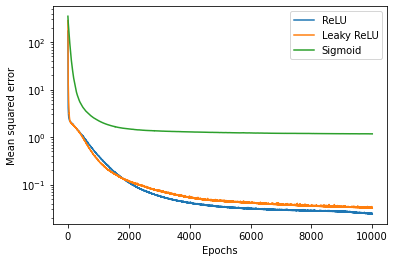

In [61]:
print(f'Best error ReLU: {min(network_relu.loss_val)}')

plt.plot(range(num_epochs), network_relu.loss_val, label='ReLU')
plt.plot(range(num_epochs), network_leakyrelu.loss_val, label='Leaky ReLU')
plt.plot(range(num_epochs), network_sig.loss_val, label='Sigmoid')
plt.xlabel('Epochs')
plt.ylabel('Mean squared error')
plt.legend()
plt.yscale('log')
plt.savefig('..\\..\\output\\figures\\NNregr_activations,10000epochs, 5batch, 0.0001alpha, 0lamb.jpg')

### Find best regularization parameter and learning rate

In [144]:
epochs = 1000
save_fig = True
num_batches = 5

# Learning rates to test
learning_rates = [ 0.00001, 0.00005, 0.00007, 0.0001, 0.0003]
# Lambdas to test
lambdas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 5, 10, 50]

# Create dictionaries to store errors
costs_train = {}
costs_val = {}

network_relu = NeuralNetwork(X_train_scaled.shape[1], activation='relu')        
network_relu.add_layer(8)
network_relu.add_layer(1)    

for learning_rate in learning_rates:
    costs_train_rate = []
    costs_val_rate = []
    for lamb in lambdas:
        network_relu.train(X_train_scaled, y_train, minibatches=num_batches, num_epochs = epochs, learning_rate=learning_rate, return_loss=True, loss='MSE', data_val=X_val_scaled, target_val=y_val, reg_coef=lamb)
        costs_train_rate.append(network_relu.loss_train[-1])
        costs_val_rate.append(network_relu.loss_val[-1])
    costs_train[learning_rate] = costs_train_rate
    costs_val[learning_rate] = costs_val_rate

In [145]:
# Create dataframs for errors
df_train = pd.DataFrame(costs_train)
df_train.index = lambdas
df_val = pd.DataFrame(costs_val)
df_val.index = lambdas

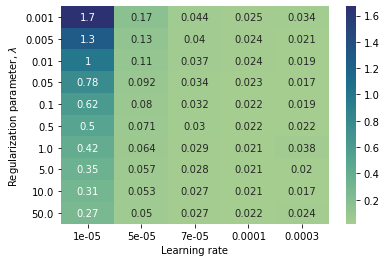

In [146]:
import seaborn as sns
sns.heatmap(df_train, annot=True, cmap="crest");
plt.ylabel(r'Regularization parameter, $\lambda$');
plt.xlabel(r'Learning rate');
plt.savefig('..\\..\\output\\figures\\heatmap_nn_train.jpg')

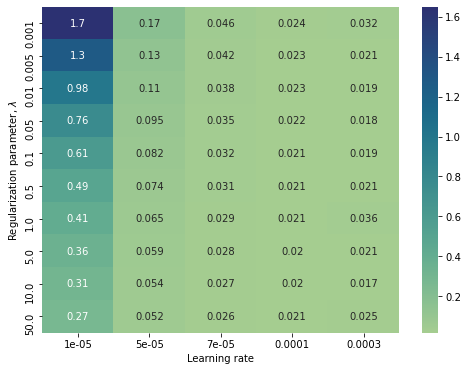

In [147]:
import seaborn as sns
plt.figure(figsize=(8,6))
sns.heatmap(df_val, annot=True, cmap="crest");
plt.ylabel(r'Regularization parameter, $\lambda$');
plt.xlabel(r'Learning rate');
plt.savefig('..\\..\\output\\figures\\heatmap_nn_val.jpg')

In [156]:
# Find test error with best hyperparameters

best_learning = 0.0001
best_lamb = 10
epochs = 10000
num_batches = 5

network_relu = NeuralNetwork(X_train_scaled.shape[1], activation='relu')        
network_relu.add_layer(8)
network_relu.add_layer(1)  

network_relu.train(X_train_scaled, y_train, minibatches=num_batches, num_epochs = epochs, learning_rate=learning_rate, reg_coef=lamb)
y_pred = network_relu.predict(X_test_scaled)
mse_test = MSE(y_pred, y_test)
mse_test

0.03301921196426128